In [57]:
import pandas as pd
import numpy as np
# encoding 
from sklearn.preprocessing import *
one_hot_encoder = OneHotEncoder()

# model 
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.metrics import *

# pipeline 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer



# neon 
from neon_db_push import *

# pkl
import joblib

In [39]:
# getting the db 
df = fetch_raw_data()

In [40]:
df["job_description_length"].unique()

array([1076, 1268, 1974, ...,  604, 1975,  723], shape=(2000,))

In [41]:
df.head()

,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,USD,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EUR,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_id                  15000 non-null  object 
 1   job_title               15000 non-null  object 
 2   salary_usd              15000 non-null  int64  
 3   salary_currency         15000 non-null  object 
 4   experience_level        15000 non-null  object 
 5   employment_type         15000 non-null  object 
 6   company_location        15000 non-null  object 
 7   company_size            15000 non-null  object 
 8   employee_residence      15000 non-null  object 
 9   remote_ratio            15000 non-null  int64  
 10  required_skills         15000 non-null  object 
 11  education_required      15000 non-null  object 
 12  years_experience        15000 non-null  int64  
 13  industry                15000 non-null  object 
 14  posting_date            15000 non-null

In [43]:
# check for duplicate values
df.duplicated().sum()

np.int64(0)

In [44]:
# check for null values
df.isnull().sum()
# there are no missing values 


job_id                    0
job_title                 0
salary_usd                0
salary_currency           0
experience_level          0
employment_type           0
company_location          0
company_size              0
employee_residence        0
remote_ratio              0
required_skills           0
education_required        0
years_experience          0
industry                  0
posting_date              0
application_deadline      0
job_description_length    0
benefits_score            0
company_name              0
dtype: int64

In [45]:
df["job_title"].unique()

array(['AI Research Scientist', 'AI Software Engineer', 'AI Specialist',
       'NLP Engineer', 'AI Consultant', 'AI Architect',
       'Principal Data Scientist', 'Data Analyst',
       'Autonomous Systems Engineer', 'AI Product Manager',
       'Machine Learning Engineer', 'Data Engineer', 'Research Scientist',
       'ML Ops Engineer', 'Robotics Engineer', 'Head of AI',
       'Deep Learning Engineer', 'Data Scientist',
       'Machine Learning Researcher', 'Computer Vision Engineer'],
      dtype=object)

In [46]:
# created a list of col name to encoded into one hot 
col_name = [
    'job_title', 'experience_level', 'employment_type',
    'company_location', 'company_size', 'employee_residence',
    'education_required', 'industry'
]

# data that does not need to be changed
num_cols = [ 'remote_ratio', 'years_experience',
    'job_description_length', 'benefits_score']

# pre processing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), col_name),
    ('num', 'passthrough', num_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


# Split data
y = df['salary_usd']
X = df.drop(columns=['salary_usd'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))

#encoded_cols = one_hot_encoder.fit_transform(df[col_name])
#feature_name_for_cols = one_hot_encoder.get_feature_names_out(col_name)

#encoded_df = pd.DataFrame(encoded_cols.toarray(),columns=feature_name_for_cols)
#encoded_df.info()



R² Score: 0.8498312280694527


In [47]:
# job lib 
joblib.dump(pipeline, 'linear_regression_pipeline.pkl')

['linear_regression_pipeline.pkl']

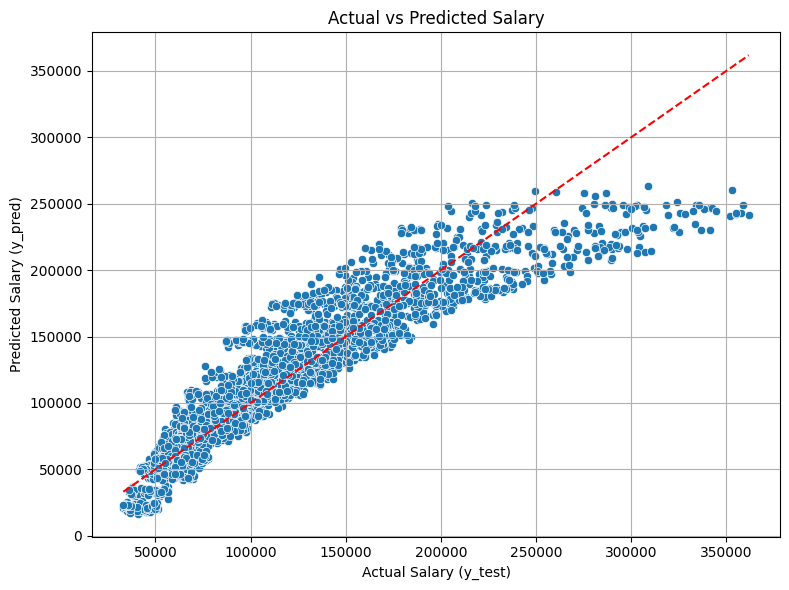

In [55]:
# actual vs predicted value
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Salary (y_test)")
plt.ylabel("Predicted Salary (y_pred)")
plt.title("Actual vs Predicted Salary")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# prediction error metrics

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.2f}") # mean absolute error
print(f"RMSE : {rmse:.2f}") #as low as this better results ( Root Mean Squared Error)
print(f"R²   : {r2:.4f}") 


MAE  : 17136.21
RMSE : 23396.95
R²   : 0.8498
